In [ ]:
# !pip install networkx
!pip install torch-geometric

In [27]:
# ---------------------- #
# General Kaggle imports #
# ---------------------- #

import os
for dirname, _, filenames in os.walk('/kaggle/input'): 
    for filename in filenames:
        print(os.path.join(dirname, filename))
import numpy as np
import pandas as pd        


# ------------------ #
# Additional imports #
# ------------------ #

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import torch
from torch import Tensor
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_features.csv
/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_classes.csv
/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv
/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_bitcoin_dataset/elliptic_txs_features.csv
/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_bitcoin_dataset/elliptic_txs_classes.csv
/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv


<img src="https://www.bitcoinsistemi.com/wp-content/uploads/2023/12/bitcoin.jpg" alt="Bitcoin Graph Image" width="800"/>

# 💰Bitcoin Transactions 🔗 Graph Neural Networks 🪙

This notebook tackles [Kaggles Elliptic Bitcoin Transaction Dataset](https://www.kaggle.com/datasets/ellipticco/elliptic-data-set/data) which maps Bitcoin transactions to real entities. In the description the objective for this dataset is described as:
> classifying the illicit and licit nodes in the graph.

[Wikipedia describes Bitcoin](https://en.wikipedia.org/wiki/Bitcoin) as the first decentralized cryptocurrency. It also states that nodes in the Bitcoin network verify transactions through cryptography and record them in a public distributed ledger, called _blockchain_. The dataset we are going to work on in this notebook is an anonymized transaction graph collexted from such Bitcoin blockchain. Kaggles Data Card describes the dataset as having the following content: 

__Dataset Content__
- _Node_: represents a transaction. 
    - Each has 166 features
    - Labeled as ✅ _licit_, ❌ _illicit_ or 🤷 _unknown_
- _Edge_: represents a flow of Bitcoins between transaction `A` and transaction `B` 

Before we start, here are a couple concepts you should know for better understanding of the following code: 

| Concept | Math Notation | Description | More Information | 
| ------- | ------------- | ----------- | ---------------- |
| Graph | $G$ | Defined as pair $G=(V,E)$, where $V$ is a set of vertices and $E$ is a set of edges which are unordered pairs ${v_1, v_2}$ of vertices. | [Wikipedia: Graph (discrete mathematics)](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)) | 
| Degree | $deg$ | Number of edges that are incident to a vertex. | [Wikipedia: Degree (graph theory)](https://en.wikipedia.org/wiki/Degree_(graph_theory)) | 
| Component | | Connected subgraph that is not part of any larger connected subgraph. | [Wikipedia: Component (graph theory](https://en.wikipedia.org/wiki/Component_(graph_theory)) | 

🚨 In the following notebook we will always call the graph $G$, the set of nodes $V$ and the set of edges $E$. 🚨

# Global Settings

In [31]:
RANDOM_STATE = 42

# Overview

Let's start by getting an overview of the datasets.

In [7]:
elliptic_txs_features = pd.read_csv('/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)
elliptic_txs_classes = pd.read_csv('/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_classes.csv')
elliptic_txs_edgelist = pd.read_csv('/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')

elliptic_txs_features.columns = ['txId'] + [f'V{i}' for i in range(1, 167)]

print(f"""Shapes
{4*' '}Features : {elliptic_txs_features.shape[0]:8,} (rows)  {elliptic_txs_features.shape[1]:4,} (cols)
{4*' '}Classes  : {elliptic_txs_classes.shape[0]:8,} (rows)  {elliptic_txs_classes.shape[1]:4,} (cols)
{4*' '}Edgelist : {elliptic_txs_edgelist.shape[0]:8,} (rows)  {elliptic_txs_edgelist.shape[1]:4,} (cols)
""")

Shapes
    Features :  203,769 (rows)   167 (cols)
    Classes  :  203,769 (rows)     2 (cols)
    Edgelist :  234,355 (rows)     2 (cols)



__Nodes & Edges__

- $|V| = 203,768$ (number of nodes in $G$)
- $|E| = 234,355$ (number of edges in $G$)

In [8]:
elliptic_txs_features.head(3)  # Dataset containing the node features.

,txId,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792


In [5]:
elliptic_txs_classes.head(3)  # Dataset containing the classes of the node.

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown


In [6]:
elliptic_txs_edgelist.head(3)  # Dataset containing the edges.

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870


Let's get an overview on the distribution of the `class`es. 

In [19]:
elliptic_txs_classes['class_mapped'] = elliptic_txs_classes['class'].replace({'1': 'illicit', '2': 'licit'})

percentage_distribution = round(100 * elliptic_txs_classes['class_mapped'].value_counts(normalize=True), 2)
class_counts = elliptic_txs_classes['class_mapped'].value_counts()

emoji_mapping = {'licit': '✅', 'illicit': '❌', 'unknown': '🤷'}
elliptic_txs_classes['emoji'] = elliptic_txs_classes['class_mapped'].map(emoji_mapping)

pd.DataFrame({
    'Class Mapped': elliptic_txs_classes['class_mapped'].unique(),
    'Class Raw': elliptic_txs_classes['class'].unique(),    
    'Counts': class_counts.values,
    'Percentage': percentage_distribution.values,
    'Emoji': [emoji_mapping[class_label] for class_label in elliptic_txs_classes['class_mapped'].unique()]
})

,Class Mapped,Class Raw,Counts,Percentage,Emoji
0,unknown,unknown,157205,77.15,🤷
1,licit,2,42019,20.62,✅
2,illicit,1,4545,2.23,❌


- 77.15% of all classes are `unknown`
- 20.62% of all classes are `licit` (2)
- 2.23% of all classes are `illicit` (1)

In [41]:
# Sampling for easier analysis...for now.
classes_sampled = elliptic_txs_classes.groupby('class_mapped').sample(frac=0.05, random_state=RANDOM_STATE)
txIds_sampled = classes_sampled['txId']

# Filter elliptic_txs_edgelist based on the sampled txIds
edgelist_sampled = elliptic_txs_edgelist[
    elliptic_txs_edgelist['txId1'].isin(txIds_sampled) | elliptic_txs_edgelist['txId2'].isin(txIds_sampled)
]

# Filter elliptic_txs_features based on the sampled txIds
features_sampled = elliptic_txs_features[elliptic_txs_features['txId'].isin(txIds_sampled)]

print(f"Sampled Classes:\n{classes_sampled['class_mapped'].value_counts()}\n")
print(f"Sampled Edgelist: {edgelist_sampled.shape[0]:,}")
print(f"Sampled Features: {features_sampled.shape[0]:,}")

Sampled Classes:
class_mapped
unknown    7860
licit      2101
illicit     227
Name: count, dtype: int64

Sampled Edgelist: 23,051
Sampled Features: 10,188


# Exploratory Data Analysis (EDA) 

## Basic Statistics

Number of nodes: 10,188
Number of edges: 23,051


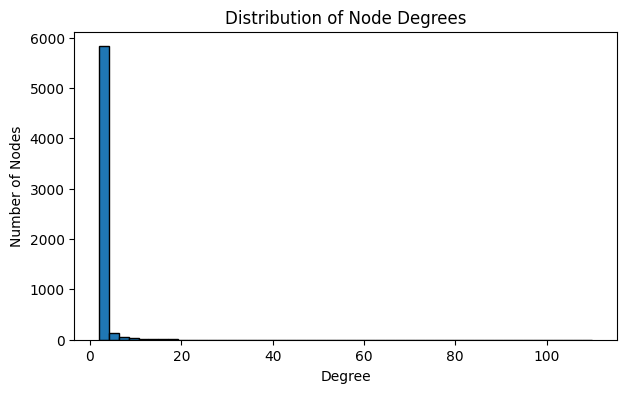

In [47]:
# Number of nodes and edges
num_nodes = features_sampled.shape[0]
num_edges = edgelist_sampled.shape[0]

print(f"Number of nodes: {num_nodes:,}")
print(f"Number of edges: {num_edges:,}")

# Distribution of node degrees
plt.figure(figsize=(7, 4))

node_degrees = edgelist_sampled['txId1'].value_counts() + edgelist_sampled['txId2'].value_counts()
node_degrees.hist(bins=50, edgecolor='black')
plt.title('Distribution of Node Degrees')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.grid(False)
plt.show()

## Graph Connectivity

In [48]:
# Create graph from the edgelist.
G = nx.from_pandas_edgelist(edgelist_sampled, 'txId1', 'txId2')

Number of connected components: 7297
Giant component - Number of nodes: 400
Giant component - Number of edges: 431


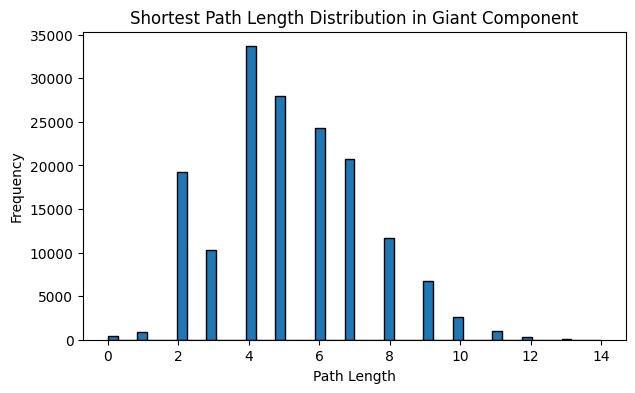

In [49]:
# --- Connected components ---
num_connected_components = nx.number_connected_components(G)
print(f"Number of connected components: {num_connected_components}")

# --- Giant component analysis ---
giant_component = max(nx.connected_components(G), key=len)
G_giant = G.subgraph(giant_component)

print(f"Giant component - Number of nodes: {G_giant.number_of_nodes():,}")
print(f"Giant component - Number of edges: {G_giant.number_of_edges():,}")


# --------------------------------------------------------- #
# Shortest paths length distribution in the giant component #
# --------------------------------------------------------- #
path_lengths = dict(nx.shortest_path_length(G_giant))
path_lengths_values = [length for target_lengths in path_lengths.values() for length in target_lengths.values()]

plt.figure(figsize=(7, 4))
plt.hist(path_lengths_values, bins=50, edgecolor='black')
plt.title('Shortest Path Length Distribution in Giant Component')
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.show()

## Node Centrality Measures

In [50]:
# Degree centrality.
degree_centrality = nx.degree_centrality(G_giant)
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes by degree centrality:")
print(top_degree_centrality)

# Betweenness centrality.
betweenness_centrality = nx.betweenness_centrality(G_giant)
top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes by betweenness centrality:")
print(top_betweenness_centrality)

# Closeness centrality.
closeness_centrality = nx.closeness_centrality(G_giant)
top_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes by closeness centrality:")
print(top_closeness_centrality)


Top 10 nodes by degree centrality:
[(22837965, 0.2756892230576441), (22837835, 0.19298245614035087), (279199578, 0.03007518796992481), (3807285, 0.02756892230576441), (279187194, 0.02756892230576441), (22837973, 0.022556390977443608), (90716926, 0.022556390977443608), (8128388, 0.022556390977443608), (22837808, 0.020050125313283207), (22838007, 0.020050125313283207)]
Top 10 nodes by betweenness centrality:
[(22837835, 0.5539593813551481), (22837965, 0.49160682621927726), (90716926, 0.1664577589455739), (22837784, 0.1655899841277657), (279187194, 0.16459106101163445), (3807285, 0.14499348231354134), (3097782, 0.11350921073122312), (8128388, 0.10370881139196399), (1435388, 0.09221921158483673), (21296808, 0.0868715838655451)]
Top 10 nodes by closeness centrality:
[(22837835, 0.3179282868525896), (22837965, 0.29381443298969073), (2203811, 0.2906045156591406), (1805107, 0.28581661891117477), (11447640, 0.28581661891117477), (2205152, 0.28581661891117477), (1367537, 0.28581661891117477), (1

## Graph Visualization

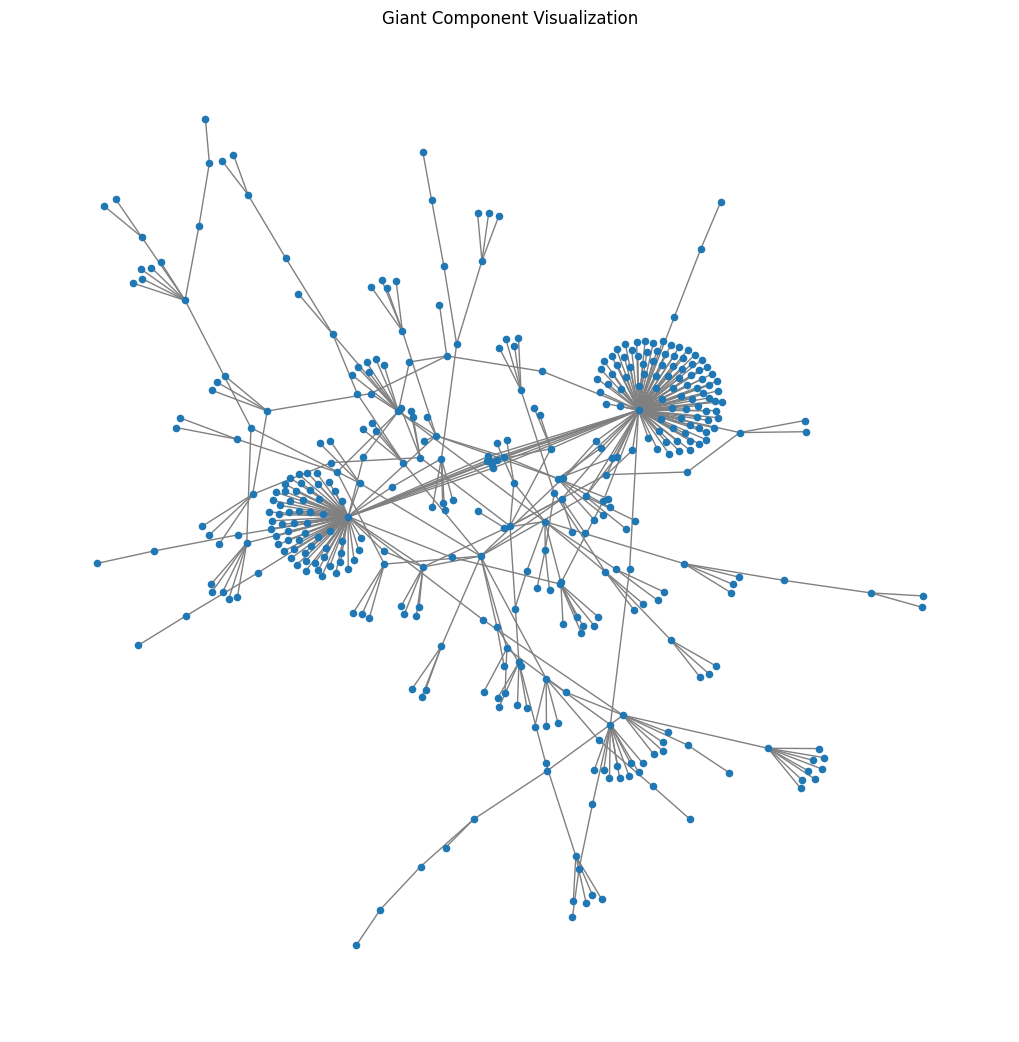

In [65]:
# ------------------------------------ #
# Visualization of the giant component #
# ------------------------------------ #

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_giant)
nx.draw(G_giant, pos, with_labels=False, node_size=20, edge_color='gray')
plt.title('Giant Component Visualization')
plt.show()

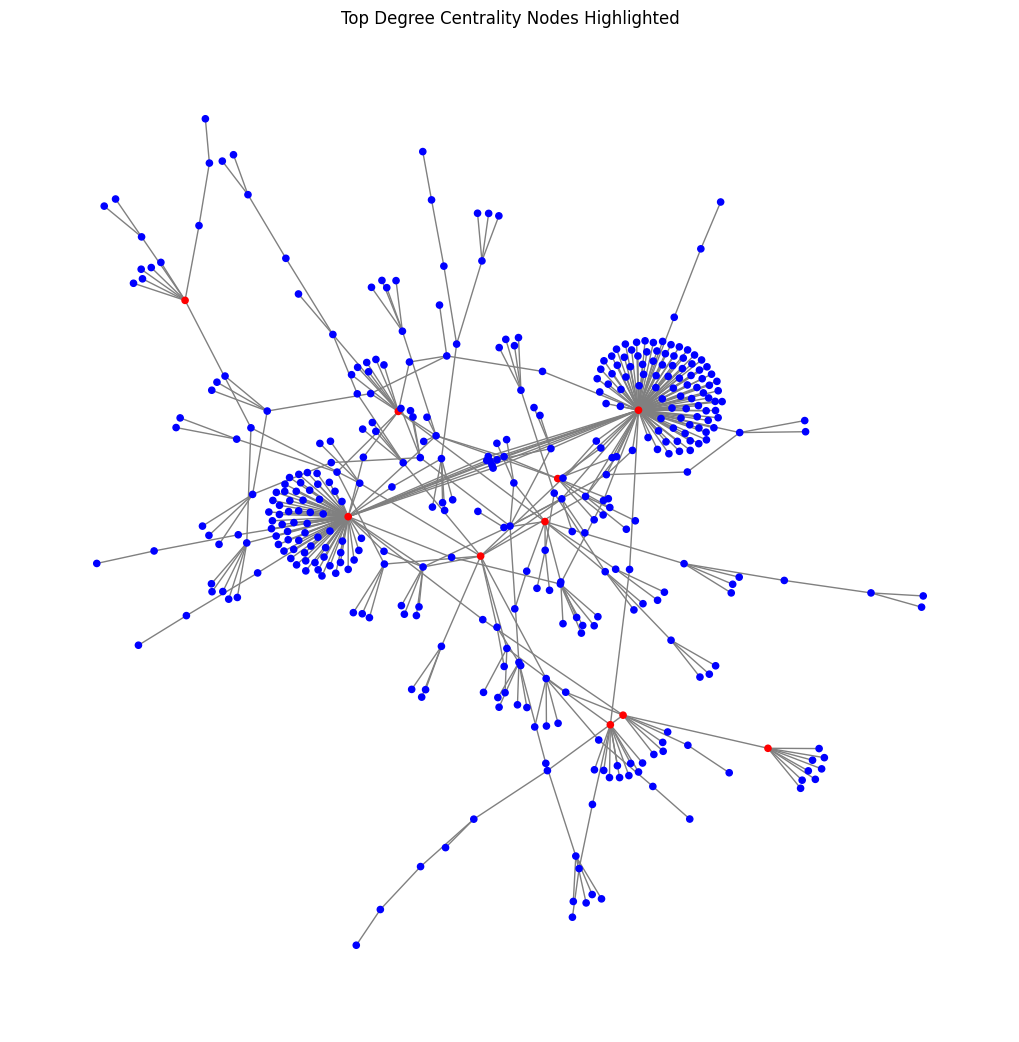

In [66]:
# ------------------------------------------- #
# Visualization of the giant component        #
# highlighting top nodes by degree centrality #
# ------------------------------------------- #

top_nodes = [node for node, centrality in top_degree_centrality]
node_color = ['red' if node in top_nodes else 'blue' for node in G_giant.nodes()]

plt.figure(figsize=(10, 10))
nx.draw(G_giant, pos, node_color=node_color, node_size=20, edge_color='gray')
plt.title('Top Degree Centrality Nodes Highlighted')
plt.show()

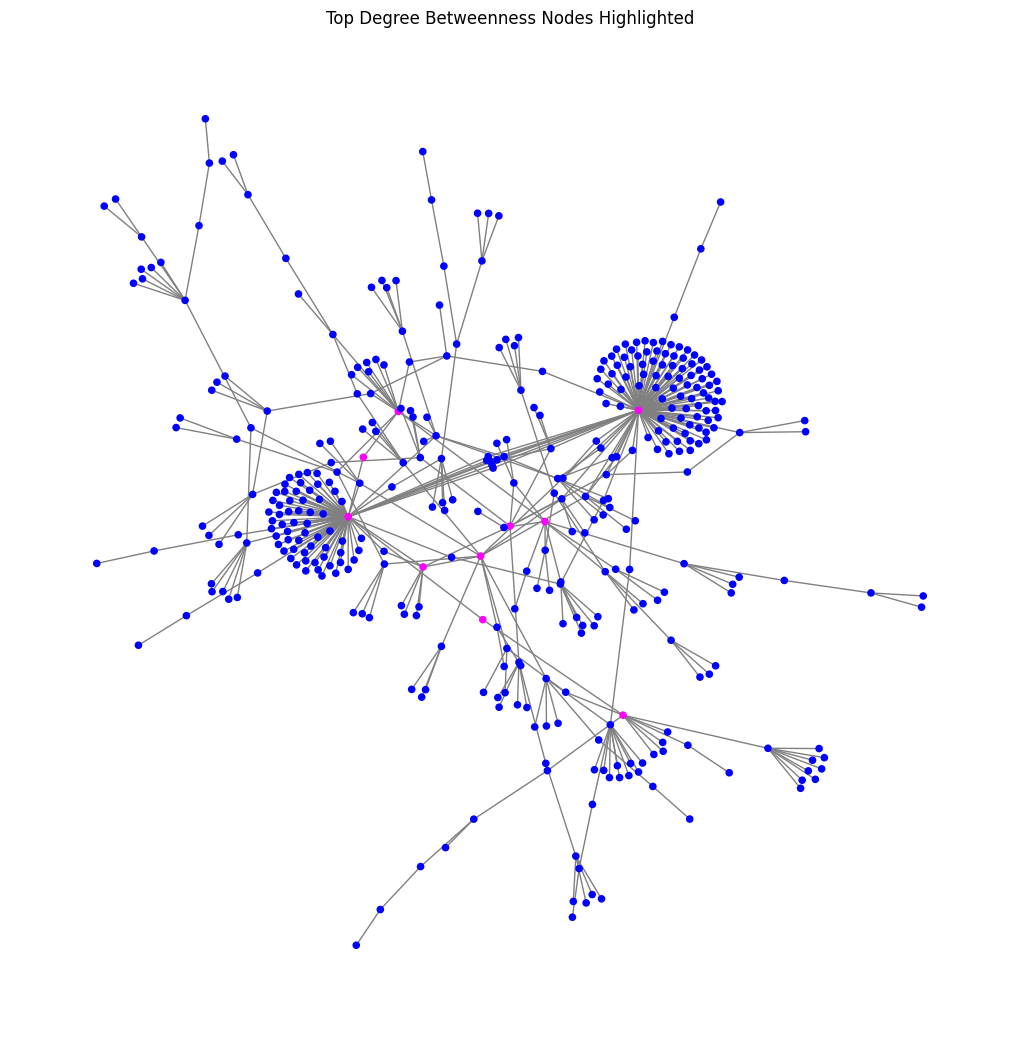

In [67]:
# ------------------------------------------------ #
# Visualization of the giant component             #
# highlighting top nodes by betweenness centrality #
# ------------------------------------------------ #

top_nodes_by_betweenness = [node for node, centrality in top_betweenness_centrality]
node_colorbetweenness = ['magenta' if node in top_nodes_by_betweenness else 'blue' for node in G_giant.nodes()]

plt.figure(figsize=(10, 10))
nx.draw(G_giant, pos, node_color=node_colorbetweenness, node_size=20, edge_color='gray')
plt.title('Top Degree Betweenness Nodes Highlighted')
plt.show()

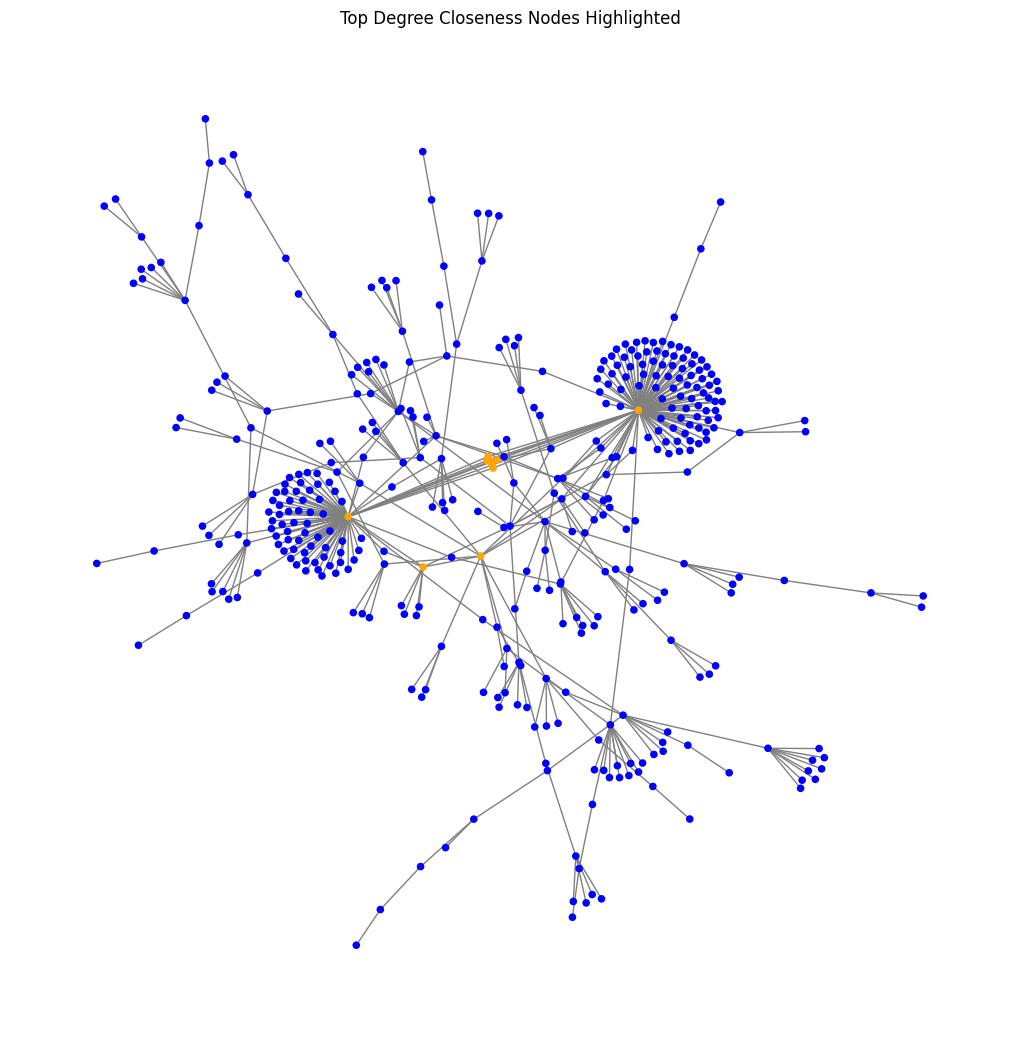

In [68]:
# ---------------------------------------------- #
# Visualization of the giant component           #
# highlighting top nodes by closeness centrality #
# ---------------------------------------------- #

top_nodes_by_closeness = [node for node, centrality in top_closeness_centrality]
node_color_closeness = ['orange' if node in top_nodes_by_closeness else 'blue' for node in G_giant.nodes()]

plt.figure(figsize=(10, 10))
nx.draw(G_giant, pos, node_color=node_color_closeness, node_size=20, edge_color='gray')
plt.title('Top Degree Closeness Nodes Highlighted')
plt.show()

## Class-specific Analysis

In [56]:
# Class-based subgraphs.
illicit_nodes = classes_sampled[classes_sampled['class_mapped'] == 'illicit']['txId']
licit_nodes = classes_sampled[classes_sampled['class_mapped'] == 'licit']['txId']

G_illicit = G.subgraph(illicit_nodes)
G_licit = G.subgraph(licit_nodes)

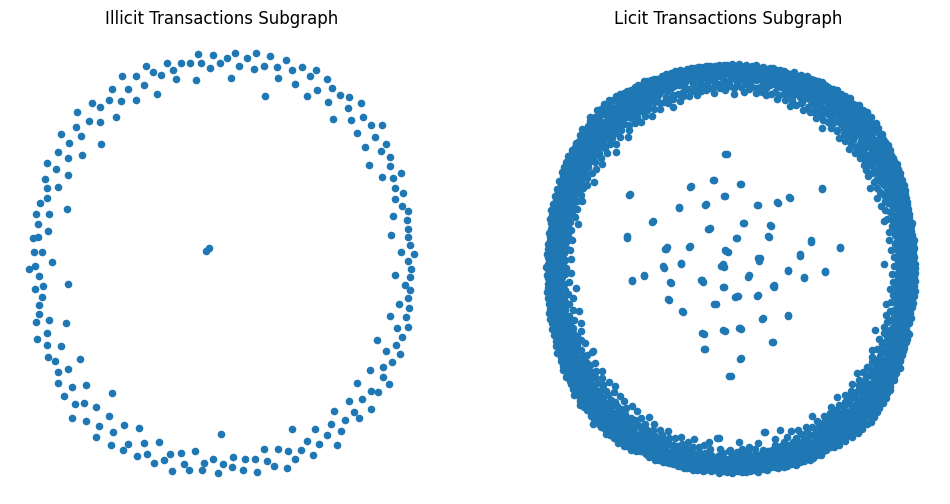

In [69]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
nx.draw(G_illicit, with_labels=False, node_size=20, edge_color='black')
plt.title('Illicit Transactions Subgraph')

plt.subplot(1, 2, 2)
nx.draw(G_licit, with_labels=False, node_size=20, edge_color='black')
plt.title('Licit Transactions Subgraph')

plt.show()

# Graph Neural Networks 

Work in Progress...

---


💚 Thank you for reading 💚

If you have any questions or feedback, feel free to leave a comment 🤔

This notebook is __still in progress__.

Please __UPVOTE__ if you enjoyed this notebook 🙏